## COVID-19 Open Research Dataset Challenge (CORD-19)
## **Authors:** Sougata Saha, Souvik Das, Rohini K. Srihari
## University at Buffalo, New York

**To summarize our architecture,** 
We build an Information Retrieval and Question Answering system using traditional Information Retrieval techniques and modern state of the art Natural Language processing techniques like 
    * Named Entity Recognition using bioBERT
    * Question Answering using BERT
    * Auto generation of question from context using BERT
    * Summarization using BERT


**REFERENCES**
* **BERT**: Pre-training of Deep Bidirectional Transformers for Language Understanding (https://arxiv.org/pdf/1810.04805.pdf)
* **BioBERT**: a pre-trained biomedical language representation model for biomedical text mining (https://arxiv.org/pdf/1901.08746.pdf)
* **bert-sklearn** (https://github.com/charles9n/bert-sklearn/blob/master/other_examples/ner_NCBI_disease_BioBERT_SciBERT.ipynb)
* **Text2Text**: generate questions and summaries for your texts (https://github.com/artitw/text2text)
* **HuggingFace's Transformers: State-of-the-art Natural Language Processing** (https://arxiv.org/pdf/1910.03771.pdf)

### Below is the overall architecture of the document retrieval system

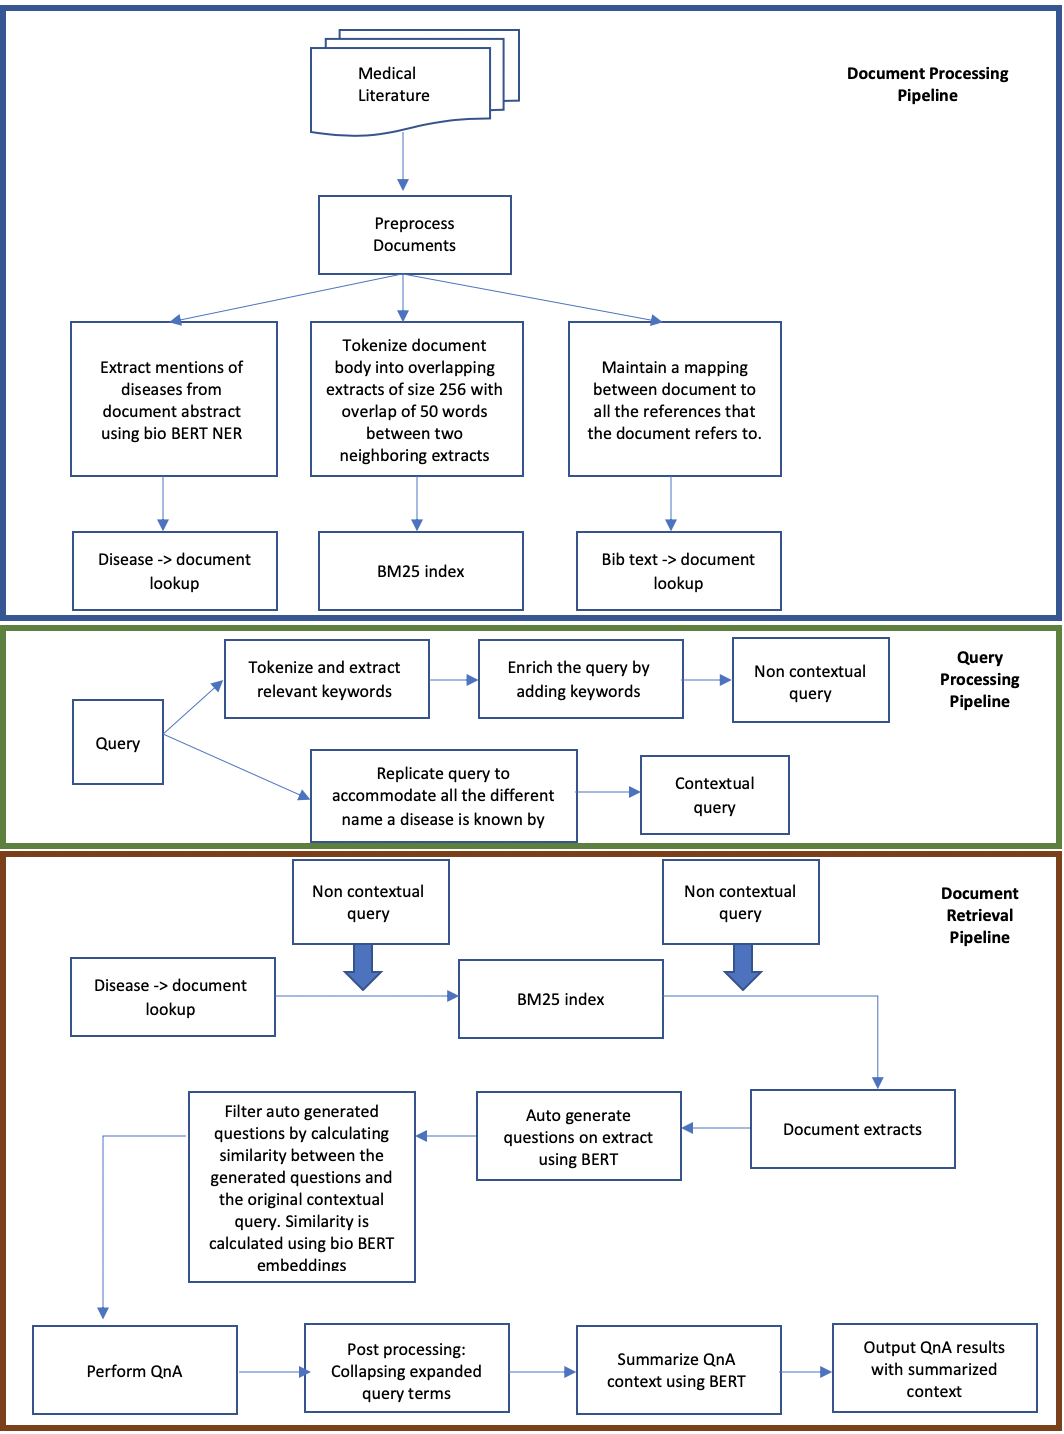

# Installing all dependencies

In [ ]:
%%bash
pip install transformers
pip install ktrain==0.12.0
pip install rank-bm25
pip install text2text
pip install fuzzywuzzy
pip install python-Levenshtein
pip install pivottablejs


In [ ]:
%%bash
pip uninstall bokeh==2.1.0 -y
pip install bokeh==1.4.0

In [ ]:
import bokeh
bokeh.__version__

In [ ]:
%%bash
git clone -b master https://github.com/charles9n/bert-sklearn
cd bert-sklearn
pip install .

In [ ]:
%%bash
export CUDA_HOME=/usr/local/cuda-10.1
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" pytorch-extension

In [ ]:
'''Testing out the text2text question generation and summarization package, 
as this package is prone to CUDA errors'''

from text2text.text_generator import TextGenerator
qg = TextGenerator(output_type="question")
sg = TextGenerator(output_type="summary")
qg.predict(['hello world'])

In [ ]:
%%bash
pip install biobert-embedding

# Training NER
### We use bioBERT to train a NER on the standard NCBI dataset to detect diseases. 
### We use this tagger to extract disease information from the abstracts of each document, and then furthur index the documents based on the disease tokens.

Code reference: https://github.com/charles9n/bert-sklearn/blob/master/other_examples/ner_NCBI_disease_BioBERT_SciBERT.ipynb

In [ ]:
%%bash
DATADIR="NCBI_disease"
if test ! -d "$DATADIR";then
    echo "Creating $DATADIR dir"
    mkdir "$DATADIR"
    cd "$DATADIR"
    wget https://raw.githubusercontent.com/allenai/scibert/master/data/ner/NCBI-disease/dev.txt
    wget https://raw.githubusercontent.com/allenai/scibert/master/data/ner/NCBI-disease/test.txt
    wget https://raw.githubusercontent.com/allenai/scibert/master/data/ner/NCBI-disease/train.txt
fi


In [ ]:

import os
import math
import random
import csv
import sys

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
import statistics as stats

sys.path.append("../") 
from bert_sklearn import BertTokenClassifier
from bert_sklearn import load_model

def read_tsv(filename, quotechar=None):
    with open(filename, "r", encoding='utf-8') as f:
        return list(csv.reader(f, delimiter="\t", quotechar=quotechar))   

def flatten(l):
    return [item for sublist in l for item in sublist]

def read_CoNLL2003_format(filename, idx=3):
    """Read file in CoNLL-2003 shared task format"""
    
    # read file
    lines =  open(filename).read().strip()   
    
    # find sentence-like boundaries
    lines = lines.split("\n\n")  
    
     # split on newlines
    lines = [line.split("\n") for line in lines]
    
    # get tokens
    tokens = [[l.split()[0] for l in line] for line in lines]
    
    # get labels/tags
    labels = [[l.split()[idx] for l in line] for line in lines]
    
    #convert to df
    data= {'tokens': tokens, 'labels': labels}
    df=pd.DataFrame(data=data)
    return df

DATADIR = "NCBI_disease/"

def get_data(trainfile=DATADIR + "train.txt",
             devfile=DATADIR + "dev.txt",
             testfile=DATADIR + "test.txt"):

    train = read_CoNLL2003_format(trainfile, idx=3)    
    dev = read_CoNLL2003_format(devfile, idx=3)
    
    # combine train and dev
    train = pd.concat([train, dev])
    print("Train and dev data: %d sentences, %d tokens"%(len(train),len(flatten(train.tokens))))

    test = read_CoNLL2003_format(testfile, idx=3)
    print("Test data: %d sentences, %d tokens"%(len(test),len(flatten(test.tokens))))
    
    return train, test

train, test = get_data()

X_train, y_train = train.tokens, train.labels
X_test, y_test = test.tokens, test.labels

print(len(train))

label_list = np.unique(flatten(y_train))
label_list = list(label_list)
print("\nNER tags:",label_list)

In [ ]:
%%time
model = BertTokenClassifier('biobert-v1.1-pubmed-base-cased',
                            max_seq_length=178,
                            epochs=4,
                            gradient_accumulation_steps=4,
                            learning_rate=3e-5,
                            train_batch_size=32,
                            eval_batch_size=64,
                            validation_fraction=0.0,                            
                            ignore_label=['O'])

print(model)

# finetune model on train data
model.fit(X_train, y_train)

# score model on test data
f1_test = model.score(X_test, y_test, 'macro')
print("Test f1: %0.02f"%(f1_test))

# get predictions on test data
y_preds = model.predict(X_test)

# print report on classifier stats
print(classification_report(flatten(y_test), flatten(y_preds)))

In [ ]:
import pandas as pd
import numpy as np
import pickle
import os
import re
import ktrain
from tqdm import tqdm
from biobert_embedding.embedding import BiobertEmbedding
from sklearn.metrics.pairwise import cosine_similarity
import json
import gensim
import nltk
import hashlib
from pivottablejs import pivot_ui
from IPython.display import HTML

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Preprocess Documents
#### The document corpus contains duplicate and near duplicate documents. We try to get the most complete information for a medical document. 
#### For cases where the metadata lacks the abstract, we directly fetch the abstract by processing the medical document(if the full text exists). 
#### In case of multiple copies of the same document, we keep the representation which gives us more information.

In [ ]:
metadata_df = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv')
metadata_df = metadata_df.fillna('')
print(metadata_df.shape)
metadata_df.head(2)

In [ ]:
#Paths
biorxiv_path = '../input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/'
comm_use_subset_path = '../input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/'
noncomm_use_subset_path = '../input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset/pdf_json/'
pmc_custom_license = '../input/CORD-19-research-challenge/custom_license/custom_license/pdf_json/'
paths = [biorxiv_path, comm_use_subset_path, noncomm_use_subset_path, pmc_custom_license]

bibtext_metadata = {}
bibtext_index = {}

In [ ]:
from tqdm import tqdm

def data_extractor(data):
    tmp = []
    paper_id = data['paper_id']
    paper_title = data['metadata']['title'].replace('Full Title: ','').replace('Short Title: ','') #add logic to keep only 1 title
    try:
        paper_abstract = data['abstract'][0]['text']
    except:
        paper_abstract = ''
    tmp_para = []
    for i in data['body_text']:
        tmp_para.append(i['text'])
    tmp_bib = []
    for k,v in data['bib_entries'].items():
        t = v['title']
        y = v['year']
        h = hashlib.sha1((str(t)+str(y)).encode()).hexdigest()
        present = bibtext_metadata.get(h)
        if present:
            bibtext_index[h].append(paper_id)
        else:
            bibtext_metadata[h] = {'title':t, 'year':y}
            bibtext_index[h] = [paper_id]
        tmp_bib.append(h)
    tmp.append([paper_id, paper_title, paper_abstract, tmp_para, tmp_bib])
    return tmp
    

all_extracts = []
for _,path in tqdm(enumerate(paths)):
    file_names = os.listdir(path)
    for _,json_file in tqdm(enumerate(file_names)):
        with open(path+json_file) as file:
            data = json.load(file)
        data2 = data_extractor(data)
        all_extracts.append(data2)
        
arr = np.array(all_extracts)
arr = arr.reshape(arr.shape[0],arr.shape[1]*arr.shape[2])
all_extracts_df = pd.DataFrame(arr, columns = ['paper_id', 'paper_title', 'paper_abstract', 
                                               'paragraphs', 'references'])
print(all_extracts_df.shape)
all_extracts_df.head(2)

metadata_df = metadata_df.merge(all_extracts_df, how='left', left_on='sha', right_on='paper_id')
print(metadata_df.shape)
metadata_df.head(2)

def enrich_abstract(original,derived):
    if original == '' and derived != '':
        return derived
    else:
        return original
metadata_df['abstract_enriched'] = metadata_df.apply(lambda x: enrich_abstract(x['abstract'],
                                                                              x['paper_abstract']), axis=1)

metadata_df = metadata_df[['sha', 'source_x', 'title', 'doi', 'publish_time', 'authors', 'journal', 
                           'abstract_enriched', 'paragraphs', 'references']]
print(metadata_df.shape)
metadata_df.head(2)
        

The above preprocessing consumes considerable memory and disk space. Hence we have performed the computations in a different environment and are directly loading the pre-computed results

In [ ]:
bibtext_metadata = pickle.load(open('../input/bibtex/bibtext_metadata.pickle', 'rb'))
bibtext_index = pickle.load(open('../input/bibtex/bibtext_index.pickle', 'rb'))
metadata_df = pickle.load(open('../input/metadata-df/metadata_df.pickle', 'rb'))

# Extracting disease terms from document abstracts using pre-trained bioBERT NER
#### We use the previously trained bioBERT NER tagger to extract disease terms fro mthe abstracts of documents. We tokenize each abstract into sentences, and then pass each sentence through the tagger.

In [ ]:
import nltk

def NER_preprocess(abstract, sha):
  op = []
  sentences = nltk.sent_tokenize(abstract)
  for sent in sentences:
    words = nltk.word_tokenize(sent)
    op.append([words, sha])
  return op

In [ ]:
from tqdm import  tqdm
sha_abstract_tokenized = []
for ix,row in tqdm(metadata_df.iterrows()):
  if str(row['abstract_enriched']) != str(np.nan) and str(row['sha']) != '' and str(row['sha']) != str(np.nan):
    tokenized_op = NER_preprocess(row['abstract_enriched'], row['sha'])
    sha_abstract_tokenized.extend(tokenized_op)


In [ ]:
sha_abstract_tokenized_df = pd.DataFrame(sha_abstract_tokenized, columns = ['tokenized_sentences',
                                                                            'sha'])
tm = [len(i) for i in list(sha_abstract_tokenized_df['tokenized_sentences'])]

Distribution of sentence lengths.
* The left distribution is the original distribution without removing outliers.
* The right distribution is the distribution after removing outliers.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tm = np.array(tm)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
sns.distplot(tm)
plt.subplot(2,2,2)
sns.distplot(tm[tm<120])

In [ ]:
#We remove sentences which have more than 120 words
sha_abstract_tokenized_df = pd.concat([sha_abstract_tokenized_df, pd.DataFrame(tm, columns=['length'])], axis=1)
sha_abstract_tokenized_df = sha_abstract_tokenized_df[sha_abstract_tokenized_df['length'] <= 120]
sha_abstract_tokenized_df = sha_abstract_tokenized_df.reset_index(drop=True)
print(sha_abstract_tokenized_df.shape)
sha_abstract_tokenized_df.head(2)

In [0]:
ner_test_data = list(sha_abstract_tokenized_df['tokenized_sentences'])
ner_test_data_tags = model.predict(ner_test_data)

In [0]:
def tag2phrases(tagged_words):
  tmp = ""
  tmp_lst = []
  prev =""
  for i,j in tagged_words:
    if j in ['B-Disease', 'I-Disease']:
      if prev in ['B-Disease', 'I-Disease'] and j =='I-Disease':
        tmp +=' '+i
      else:
        if len(tmp) > 0:
          tmp_lst.append(tmp.lower())
        tmp = i
    prev = j
  if len(tmp) > 0:
    tmp_lst.append(tmp.lower())
  return tmp_lst


In [0]:
doc_disease_terms_dict = {}

for ix,row in tqdm(sha_abstract_tokenized_df.iterrows()):
  sha = row['sha']
  words = row['tokenized_sentences']
  tags = ner_test_data_tags[ix]
  tagged_words = zip(words, tags)
  tagged_phrases = tag2phrases(tagged_words)
  if len(tagged_phrases) >0:
    try:
      doc_disease_terms_dict[sha].extend(tagged_phrases)
    except:
      doc_disease_terms_dict[sha] = tagged_phrases
print(len(doc_disease_terms_dict))

We have precomputed the predictions in a different environment. We directly load the outputs here

In [ ]:
doc_disease_terms_dict = pickle.load(open('../input/doc-disease/doc_disease_terms_dict.pickle', 'rb'))

**Distribution of disease terms in the corpus abstracts**

In [ ]:
from collections import Counter
all_terms = []
for k,v in doc_disease_terms_dict.items():
    all_terms.extend(v)
    
{k: v for k, v in sorted(dict(Counter(all_terms)).items(), key=lambda item: item[1], reverse=True)}

# Preprocess 2 : Generating extracts from text
#### We tokenize the body of a document into extracts of length 256 with overlap of 32 tokens between neighbouring extracts (this is mainly done to overcome the token restriction of 512 in BERT)

In [ ]:
def generate_cuts(lst, length, overlap):
    '''
    Generates overlapping extracts from the text body or abstract of a paper
    '''
    txt = ""
    cuts = []
    txt = " ".join(lst)
    txt = txt.strip()
    words = txt.split(" ")
    word_len = len(words)
    
    st = 0
    en = st+length
    all_done = False
    
    while en <= word_len:
        if en >= word_len:
            all_done=True
        cut = " ".join(words[st:en])
        cuts.append(cut)
        st = en - overlap
        en = st + length
        
    if not all_done:
        cut = " ".join(words[st:])
        cuts.append(cut)
        
    return cuts

In [ ]:
#Dictionary which stores the extract at a paper+extractnumber level
extract_dict = {}
#Dictionary which the relation between a paper and the paper+extractnumbers
extract_dict_index = {}
#Dictionary which stores how a paper is currently indexed(whether the abstract or the paragraph)
index_status = {}

def store_data(extracts, sha, iden):
    '''
    Checks if and how the current document is indexed.
    If index_checker returns True, then index the generated multiple extracts of the current document
    '''
    to_index = index_checker(sha, iden)
    if to_index:
        tmp = []
        for i,e in enumerate(extracts):
            uniq_id = str(sha)+"_"+str(i)+iden
            extract_dict[uniq_id] = e
            tmp.append(uniq_id)
        extract_dict_index[sha] = tmp
        index_status[sha] = iden
    else:
      pass
      #print("not indexed")

def remove_old_data(sha):
    '''
    Deletes old extracts. Only used if duplicate records with same sha is found, where the latest record,
    has additional information compared to the old one
    '''
    extract_ids = extract_dict_index[sha]
    for i in extract_ids:
        del extract_dict[i]
    
def index_checker(sha, current_iden):
    try:
        '''
        Check if the current document is already indexed. If it is, then check whether it was indexed by the
        text body or abstract.
        If currently we have the text body, and if previously it was indexed by abstract, then update
        the index using text body. Else don't change the index
        If the current document is not indexed, then index the document
        '''
        iden = index_status[sha]
        if current_iden == "A" and iden == "P":
            return False
        elif current_iden == "P" and iden == "A":
            index_status[sha] = "P"
            remove_old_data(sha)
            return True
        else:
            return False
        
    except:
        index_status[sha] = current_iden
        return True
    
not_indexed = []  
for ix,row in tqdm(metadata_df.iterrows()):
    paragraphs = row['paragraphs']
    abstract = row['abstract_enriched']
    sha = row['sha']

    #generate extracts of 300 length, with overlap of 50 words with the previous extract
    if type(paragraphs) == list:
        #print(ix, "P")
        extracts = generate_cuts(paragraphs, 256, 32)
        store_data(extracts, sha, "P")
        
    else:
        #print(ix, "A")
        if str(abstract) != str(np.nan):
            extracts = generate_cuts(abstract, 256, 32)
            store_data(extracts, sha, "A")
        else:
            #print("nan abstract")
            not_indexed.append(sha)



In [ ]:
multi_level_doc_dict = {}
multi_level_doc_dict_reverse = {}
doc_dict = {}
for k,v in tqdm(extract_dict.items()):
  sha, para = k.split('_')
  multi_level_doc_dict_reverse[v] = sha
  try:
    multi_level_doc_dict[sha][para] = v
    doc_dict[sha] = ". ".join([doc_dict[sha] + v])
  except:
    multi_level_doc_dict[sha] = {}
    multi_level_doc_dict[sha][para] = v
    doc_dict[sha] = v

In [ ]:
print(len(multi_level_doc_dict), len(doc_dict))

In [ ]:
doc_dict_reverse = {}
for k,v in doc_dict.items():
  doc_dict_reverse[v] = k

In [ ]:
import hashlib
def make_uniq_id(s):
    return hashlib.sha1(s.encode()).hexdigest()

In [ ]:
doc_dict_encoded = {}
for k,v in doc_dict.items():
  doc_dict_encoded[make_uniq_id(v)] = k

# LDA Topic Modelling
#### We try to see the concepts that the corpus contains by performing LDA. 

In [ ]:
#Creating LDA model on the body
%time
topic_model = ktrain.text.get_topic_model(list(doc_dict.values()), n_topics = 7)

In [ ]:
%%time
topic_model.build(list(doc_dict.values()), threshold=0.25)

In [ ]:
topic_model.print_topics(show_counts=True)

In [ ]:
topic_model.visualize_documents(doc_topics=topic_model.get_doctopics())

# Information Retrieval and Question Answering with BERT:

## Levinstein similarity -> BM25 -> BERT Question generation -> BERT Question Answering -> BERT Summarization

#### We have implemented a composite approach comprising of traditional IR techniques and models like BM25, and more advanced NLP techniques like question answering, question generation and summarization using BERT architecture

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(device)

In [ ]:
import torch

from transformers import BertForQuestionAnswering, BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_qna_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
bert_qna_model.cuda();

In [ ]:
disease_dict = {"mers":["mers", "mers-cov", "middle east respiratory syndrome"],
"sars":["sars","sars-cov", "severe acute respiratory syndrome"],
"ncovid":["ncov-19", "covid-19", "ncovid", "novel coronavirus", "sars-cov-2"]} 

disease_dict_reverse = {}
for k,v in disease_dict.items():
  for v2 in v:
    disease_dict_reverse[v2] = k


In [ ]:
from rank_bm25 import BM25Okapi

def make_model(corpus):
  tokenized_corpus = [doc.split(" ") for doc in corpus]
  bm25 = BM25Okapi(tokenized_corpus)
  return bm25

In [ ]:
def tokenize_query(txt, disease="ncovid"):
  txt = gensim.utils.simple_preprocess(txt, deacc=True)
  query = [word for word in txt if word not in stopwords.words('english')]
  disease_terms = " ".join(disease_dict[disease]).split(' ')
  query = list(set(query + disease_terms))
  return query

In [ ]:
def perform_qna(question, text):
  input_ids = tokenizer.encode(question, text)
  input_ids = input_ids[:512]
  token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
  start_scores, end_scores = bert_qna_model(torch.tensor([input_ids]).to(device), 
                                 token_type_ids=torch.tensor([token_type_ids]).to(device))
  all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  answer = ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])
  answer = answer.split(" ")
  ans = []
  for a in answer:
    try:
      if a[:2] == "##":
        ans[-1]+=a[2:]
    except:
      print ("EXCEPTION !!!!!")
      print(a, ans)
      ans.append(a)
    else:
      ans.append(a)
  answer = " ".join(ans)
  return answer

In [ ]:
def generate_questions(text, n_ques=20):
  qna = qg.predict([text]*n_ques)
  return qna

In [ ]:
def generate_summary(text, summary_questions = 5):
  summary = sg.predict([text])[0]
  summary = summary.replace('[X_SEP]', '')
  if summary_questions > 0:
    summary_qna = generate_questions(summary, summary_questions)
  else:
    summary_qna = None
  return summary, summary_qna

In [ ]:
biobert = BiobertEmbedding()

def filter_generated_questions(generated_questions, actual_question, threshold = 0.85, k1=3, k2=3):
  ques_to_preserve = []
  similarity_scores = []
  final_ques_lst_sim = []
  final_ques_lst_dissim = []
  acutal_question_emb = biobert.sentence_vector(actual_question).detach().cpu().numpy().reshape(1,768)

  for ques in generated_questions:
    emb = biobert.sentence_vector(ques).detach().cpu().numpy().reshape(1,768)
    similarity = cosine_similarity(acutal_question_emb, emb).item()
    if similarity >= threshold:
      ques_to_preserve.append(ques)
      similarity_scores.append(similarity)
  lst = list(zip(ques_to_preserve, similarity_scores))
  lst.sort(key = lambda x: x[1], reverse=True)
  for i in lst[:k1]:
    final_ques_lst_sim.append(i[0])

  lst.sort(key = lambda x: x[1], reverse=False)
  for i in lst[:k2]:
    final_ques_lst_dissim.append(i[0])
  return final_ques_lst_sim, final_ques_lst_dissim

In [ ]:
def make_bm25_model(doc_list, primary_disease):
  model_name = primary_disease
  if topic2model.get(model_name) == None:
    print("Creating BM25 model ", model_name)
    model = make_model(doc_list)
    topic2model[model_name] = {}
    topic2model[model_name]['model'] = model
    topic2model[model_name]['corpus'] = doc_list
    return model
  else:
    print("Retrieving BM25 model ",model_name)
    return topic2model[model_name]['model']

In [ ]:
#dictionary with disease-> doc mapping
disease2doc = {}
for k,v in doc_disease_terms_dict.items():
  for d in v:
    try:
      disease2doc[d].append(k)
    except:
      disease2doc[d] = [k]
for k,v in disease2doc.items():
  disease2doc[k] = list(set(v))

In [ ]:
def get_docs_for_disease(disease_list, threshold = 88):
  docs = []
  for d in disease_list:
    for d2 in list(disease2doc.keys()):
      score = fuzz.ratio(d, d2)
      if score >= threshold:
        docs.extend(disease2doc[d2])   
  return [v for s in list(set(docs)) for k,v in multi_level_doc_dict[s].items()]

In [ ]:
def search(disease_tokens, query_tokens, contextual_query, primary_disease,k=10, 
           auto_generate_questions = True, limit_autogeneration = 5):
  
  contextual_query_list_filtered = []
  contextual_query_list_unfiltered = []
  auto_generated_ques = []
  context = []
  op = []

  disease_docs = get_docs_for_disease(disease_tokens)
  bm25_model = make_bm25_model(disease_docs, primary_disease)
  top_k = bm25_model.get_top_n(query_tokens, topic2model[primary_disease]['corpus'], n=k)
  context.extend(top_k)

  if auto_generate_questions:
    print("Auto generating questions")
    for i in top_k[:limit_autogeneration]:
      qna = generate_questions(i)
      auto_generated_ques.extend(qna)

    for qu,an in auto_generated_ques:
      all_generated_short_questions.append([qu, an])

  if len(auto_generated_ques) > 0:
    for auto in auto_generated_ques:
      contextual_query_list_unfiltered.append(auto[0])

  contextual_query_list_unfiltered = list(set(contextual_query_list_unfiltered))
  print("\n Total contexts = ",len(context))
  print("\n Total contextual questions unfiltered = ",len(contextual_query_list_unfiltered))
  contextual_query_list_filtered, dissimilar_q  = filter_generated_questions(contextual_query_list_unfiltered, 
                                                        contextual_query, k1=3, k2=3)
  for dis in disease_dict[primary_disease]:
    contextual_query_list_filtered.append(contextual_query.replace('coronavirus', dis))

  print("Total contextual questions after filtering : ", len(contextual_query_list_filtered))
  print("Total contextual dissimilar questions after filtering : ", len(dissimilar_q))
  print("Performing QnA Filtered")
  for i in context:
    for q in contextual_query_list_filtered:
      answer = perform_qna(q, i)
      if ('[CLS]' not in answer) and ('[SEP]' not in answer) and (answer != ''):
        op.append([answer, q, i, 'similar_q'])

    for q2 in dissimilar_q:
      answer2 = perform_qna(q2, i)
      if ('[CLS]' not in answer2) and ('[SEP]' not in answer2) and (answer2 != ''):
        op.append([answer2, q2, i, 'dissimilar_q'])

  return op, context

## Below is the list of queries for which we want to retrieve documents and answers from the corpus

In [ ]:
questions = {
    "Range of incubation periods for the disease in humans":\
    ["What is the incubation period of coronavirus in humans?",
     "What is the age wise incubation period of cornavirus in humans?",
     "What happens to people affected by coronavirus post recovery?",
     "How long does it take for humans to recover from coronavirus?"],

    "Prevalence of asymptomatic shedding and transmission.":\
     ["Does coronavirus transmit asymptomatically in humans?",
      "Asymptomatic transmission of coronavirus in humans"],

    "Seasonality of transmission.":\
      ["What is the seasonality of coronavirus?",
       "Which season did coronavirus appear?"],

    "Physical science of the coronavirus":\
    ["What is the coronavirus made of?",
     "What does the coronavirus look like?",
     "How does coronavirus shed?",
     "Viral shedding"],

    "Persistence and stability on a multitude of substrates and sources":\
    ["What is known about environmental stability of coronavirus?",
     "What surfaces does coronavirus survive?",
     "What substrates does coronavirus survive?",
     "What is the stability of coronavirus?",
     "How long does coronavirus stay active on metals?",
     "How long does coronavirus stay active on skin?",
     "How long does coronavirus stay active on plastic?"]
     ,

    "History of coronavirus ans transmission":\
     ["What is the history of coronavirus?",
      "How does coronavirus transmit?"],

    "Diagnosing coronavirus":\
    ["How can we diagnose coronavirus?"],

    "Tools and studies to monitor phenotypic change and potential adaptation of the virus":\
    ["What are the tools to study phenotypic change of cornavirus?",
     "What are the potential adaptation of coronavirus?"],

    "Coronavirus immunity and control":\
    ["How to get immune from coronavirus?",
     "How can coronavirus be controlled?",
     "How to limit the spread of coronavirus?",
     "How effective is personal protective equipment against coronavirus?"],

    "Role of the environment in transmission":\
    ["How does coronavirus spread through water?",
     "How does coronavirus spread through air?",
     "How does coronavirus transmit in the environment?"]

}


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
topic2model = {}
all_generated_short_questions = []
op_dict = {}

The below code iteratively fires query and retrieves the results

In [ ]:
from fuzzywuzzy import fuzz

number_of_docs = 20


#op dict hierarchy : topic -> question -> disease -> search_op & context

for k,v in questions.items():
  op_dict[k] = {}
  print("Topic "+k)
  print("-------------------------------\n")
  for q in v:
    print("Question "+q+"\n")
    op_dict[k][q] = {}
    for disease, disease_alternates in disease_dict.items():
      op_dict[k][q][disease] = {}
      print("Running for disease "+disease+"\n")
      query_tokens = tokenize_query(q.replace('coronavirus', ''), disease)
      search_op, context = search(disease_alternates, query_tokens, q, disease, 
                                  k=number_of_docs, auto_generate_questions = True, 
                                  limit_autogeneration = 3)
      op_dict[k][q][disease]['search_op'] = search_op
      op_dict[k][q][disease]['context'] = context
      print(search_op)
      print("_______________________________________\n")
    
    print("=====================================\n")
  

Since we are using BERT at multiple stages, the above code requires good amount of resources and time. We have pre-computed the resutls in a different environment and have loaded them below directly

In [ ]:
op_dict = pickle.load(open('../input/qna-results/op_dict_20200413.pickle', 'rb'))
all_generated_short_questions = pickle.load(open('../input/qna-results/all_generated_short_questions_20200413.pickle', 'rb'))

# Post processing results and presenting outputs
#### Below we post process and format the retrieved results, and present the output using interactive widgets

In [ ]:
def summarize_context(context):
  context_summary = sg.predict([context])
  return context_summary[0].replace('[X_SEP]', '')

In [ ]:
def standardize_question(q, alternate_disease_names, disease):
  for alt in alternate_disease_names:
    q = re.sub(r"\b%s\b" % alt, disease, q)
  return q

In [ ]:
def get_top_k_questions(reference, generated, alternate_disease_names, disease):
  q_sim = {}

  reference = biobert.sentence_vector(reference).detach().cpu().numpy().reshape(1,768)
  for g in generated:
    emb = biobert.sentence_vector(g).detach().cpu().numpy().reshape(1,768)
    q_sim[g] = cosine_similarity(reference, emb).item()

  q_sim = sorted(q_sim.items(), key=lambda x:-x[1])[:3]

  return [[q[0],standardize_question(q[0], alternate_disease_names, disease)] for q in q_sim]

In [ ]:
def format_data(topic, question, disease):
  qna_op = op_dict[topic][question][disease]['search_op']
  context_op = op_dict[topic][question][disease]['context']
  alternate_disease_names = disease_dict[disease]
  qna_similar = []
  qna_dissimilar = []
  top_similar_q = []
  summarized = {}
  summary = []
  for i in qna_op:
    if i[-1] == 'similar_q':
      qna_similar.append(i)
      top_similar_q.append(i[1])
    else:
      qna_dissimilar.append(i)

  top_ques = pd.DataFrame(get_top_k_questions(question, top_similar_q, 
                                 alternate_disease_names, disease),
                          columns = ['ques', 'standardize_question'])

  filtered_df = pd.DataFrame(qna_op, columns = ['answer', 'ques', 
                                                'context','sim'])\
                                                .merge(top_ques,
                                                       how = 'inner', 
                                                       on = 'ques')\
                                                .drop_duplicates()

  tmp_op = filtered_df[['answer', 'standardize_question', 'context']]\
                                                .drop_duplicates()
  for ix, row in tmp_op.iterrows():
    try:
      summary.append(summarized[row['context']])
    except:
      summarized[row['context']] = summarize_context(row['context'])
      summary.append(summarized[row['context']])

  tmp_op = pd.concat([tmp_op, pd.DataFrame(summary, columns=['context_summary'])] 
                     , axis=1)

  return tmp_op, list(summarized.keys())

In [ ]:
import matplotlib.pyplot as plt
import plotly
import ipywidgets as widgets
from IPython.display import display
import plotly.offline as py
from plotly.offline import iplot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.tools as tls
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True,  theme='pearl')
import folium
import altair as alt
import missingno as msg
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from ipywidgets import interact, interactive, fixed
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

pd.set_option('display.max_colwidth', -1)

%matplotlib inline


In [ ]:
import networkx as nx
import seaborn as sns
from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,Oval,LinearColorMapper,
                          BoxSelectTool, EdgesAndLinkedNodes,
                           NodesAndLinkedEdges, TapTool)
from bokeh.palettes import Spectral4
from bokeh.models.graphs import from_networkx
from bokeh.io import output_notebook
import matplotlib
import matplotlib.pyplot as plt
output_notebook()

def make_plot(context):

  graph_points = []
  for cont in context:
    doc_sha = multi_level_doc_dict_reverse[cont]
    doc_references = metadata_df[metadata_df['sha'] == doc_sha]['references'].item()
    ref_titles = [bibtext_metadata[ref]['title'] for ref in doc_references]
    doc_title = metadata_df[metadata_df['sha'] == doc_sha]['title'].item()
    graph_points.extend(list(zip([doc_title]*len(ref_titles), ref_titles)))
  graph_points = list(set(graph_points))

  uniq = []
  for i in graph_points:
    uniq.append(i[0])
  uniq = list(set(uniq))

  palette = sns.color_palette("cubehelix", 20)
  pal_hex_lst = palette.as_hex()
  colors = iter(pal_hex_lst)

  node_colors = {}
  for u in uniq:
    node_colors[u] = next(colors)

  G = nx.DiGraph()
  G.add_edges_from(graph_points)
  edge_attrs = {}
  node_attrs = {}

  for start_node, end_node, _ in G.edges(data=True):
    edge_color = node_colors[start_node]
    edge_attrs[(start_node, end_node)] = edge_color

  nx.set_edge_attributes(G, edge_attrs, "edge_color")


  for start_node, _ in G.nodes(data=True):
    node_color = node_colors[start_node] if start_node in node_colors.keys() else 'gray'
    node_attrs[(start_node)] = node_color

  nx.set_node_attributes(G, node_attrs, 'node_color')
  # Show with Bokeh
  plot = Plot(plot_width=600, plot_height=600,x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
  #figure(plot_width=600, plot_height=600)
  # plot.min_border_top = 10
  # plot.min_border_bottom = 10
  # plot.min_border_left = 300
  # plot.min_border_right = 10
  #Plot(plot_width=600, plot_height=600,x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
  plot.title.text = "Bibtext references"

  node_hover_tool = HoverTool(tooltips=[("index", "@index"),
                                      ("color", "$color[swatch]:node_color")])
  
  plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), TapTool(), BoxSelectTool())

  graph_renderer = from_networkx(G, nx.circular_layout, center=(0, 0), scale=1)

  graph_renderer.node_renderer.glyph = Circle(size=15,fill_color={'field': 'node_color'})
  graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color={'field': 'node_color'})
  graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color={'field': 'node_color'})


  graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=6)
  graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=6)
  graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=6)


  graph_renderer.selection_policy = NodesAndLinkedEdges()
  graph_renderer.inspection_policy = NodesAndLinkedEdges()

  plot.renderers.append(graph_renderer)
  show(plot)

In [ ]:
import plotly.graph_objects as go

def df2table(df):
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    font = dict(color = 'darkslategray', size = 11),
                align = ['left', 'center']),
        cells=dict(values=[df.answer, df.standardize_question, 
                           df.context, df.context_summary],
                   font = dict(color = 'darkslategray', size = 11),
               align = ['left', 'center'],height=400))
    ])
    fig.update_layout(width=1100, height=1100)
    fig.show()

In [ ]:
from ipywidgets.embed import embed_minimal_html

def get_widget(df):
    ALL = 'ALL'
    def unique_sorted_values_plus_ALL(array):
        unique = array.unique().tolist()
        unique.insert(0, ALL)
        return unique

    dropdown_answer = widgets.SelectMultiple(options =  unique_sorted_values_plus_ALL(df.answer),
                                             rows=10,disabled=False,
                                            description = 'Answer Filter')

    button = widgets.Button(description="Filter Output")
    output_ans = widgets.Output()
    
    def dropdown_answer_eventhandler(change):
        output_ans.clear_output()
        if (ALL in change.new):
            df2table(df)
            make_plot(list(set([i for i in list(df['context']) if str(i) != str(np.nan)])))
        else:
            df2table(df[df.answer.isin(change.new)])
            make_plot(list(set([i for i in list(df[df.answer.isin(change.new)]['context']) if str(i) != str(np.nan)])))
            
        with output_ans:
            if (ALL in change.new):#if (change.new == ALL):
                display(df)
            else:
                display(df[df.answer.isin(change.new)])
                
    def on_buttn_click(b):
        dropdown_answer.observe(dropdown_answer_eventhandler, names='value')
        
    display(dropdown_answer, button)
    display(output_ans)
    button.on_click(on_buttn_click)


# Reporting results
### We attempted to process the corpus of medical literature and show side by side comparison between MERS, SARS and COVID-19.
### The motivation being that we can find something in the literature of different viruses(MERS and SARS), which can help in answering the unaswered questions of COVID-19

## **How to read the reports?** 
* The most relevant answers have been filtered and presented. 
* The tables are interactive in nature, and the columns can be repositioned for ease
* The tables have scroll enabled in them.
* A graph is generated below each table. The graph denotes the references of the papers from which the context in the table is derived.
* The nodes(small circles) denote each paper. 
* A gray node is a paper which is referenceds, but not present in the corpus.
* A coloured node is the paper based on which the context in the table is derived
* The graph is interactive. You can hover over the nodes to see the name of the paper.
* Hovering over the node highlights the edges.
* Also sorry for the cluttered representation. Kaggle notebooks don't support ipywidgets in static pages yet. Hence had to implement a hacky workaround around the problem, at a cost of a bit cluttered representation.

# Comparison of range of incubation periods of SARS, MERS and COVID-19

In [ ]:
topic = "Range of incubation periods for the disease in humans"
question = "What is the incubation period of coronavirus in humans?"
disease = "mers"

format_data_df,context_for_summ = format_data(topic, question, disease)

#pivot_ui(format_data_df)
# df = format_data_df

get_widget(format_data_df)

In [ ]:
topic = "Range of incubation periods for the disease in humans"
question = "What is the incubation period of coronavirus in humans?"
disease = "sars"

format_data_df2,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df)
get_widget(format_data_df2)

In [ ]:
topic = "Range of incubation periods for the disease in humans"
question = "What is the incubation period of coronavirus in humans?"
disease = "ncovid"

format_data_df3,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df3)

# Post recovery effects of SARS, MERS and COVID-19

In [ ]:
topic = "Range of incubation periods for the disease in humans"
question = "What happens to people affected by coronavirus post recovery?"
disease = "mers"

format_data_df4,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df4)

In [ ]:
topic = "Range of incubation periods for the disease in humans"
question = "What happens to people affected by coronavirus post recovery?"
disease = "sars"

format_data_df5,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df5)

In [ ]:
topic = "Range of incubation periods for the disease in humans"
question = "What happens to people affected by coronavirus post recovery?"
disease = "ncovid"

format_data_df6,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df6)

# Diagnosing SARS, MERS and COVID-19

In [ ]:
topic = "Diagnosing coronavirus"
question = 'How can we diagnose coronavirus?'
disease = "mers"

format_data_df7,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df7)

In [ ]:
topic = "Diagnosing coronavirus"
question = 'How can we diagnose coronavirus?'
disease = "sars"

format_data_df8,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df8)

In [ ]:
topic = "Diagnosing coronavirus"
question = 'How can we diagnose coronavirus?'
disease = "ncovid"

format_data_df9,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df9)

# Prevalence of asymptomatic shedding and transmission SARS, MERS and COVID-19

In [ ]:
topic = "Prevalence of asymptomatic shedding and transmission."
question = 'Asymptomatic transmission of coronavirus in humans'
disease = "mers"

# format_data_df,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df)

In [ ]:
topic = "Prevalence of asymptomatic shedding and transmission."
question = 'Asymptomatic transmission of coronavirus in humans'
disease = "sars"

format_data_df2,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df2)

In [ ]:
topic = "Prevalence of asymptomatic shedding and transmission."
question = 'Asymptomatic transmission of coronavirus in humans'
disease = "ncovid"

format_data_df3,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df3)

# Physical science of SARS, MERS and COVID-19

In [ ]:
topic = "Physical science of the coronavirus"
question = 'What is the coronavirus made of?'
disease = "mers"

format_data_df1,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df1)

In [ ]:
topic = "Physical science of the coronavirus"
question = 'What is the coronavirus made of?'
disease = "sars"

format_data_df2,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df2)

In [ ]:
topic = "Physical science of the coronavirus"
question = 'What is the coronavirus made of?'
disease = "ncovid"

format_data_df3,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df3)

In [ ]:
topic = "Physical science of the coronavirus"
question = 'What does the coronavirus look like?'
disease = "mers"

format_data_df4,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df4)

In [ ]:
topic = "Physical science of the coronavirus"
question = 'What does the coronavirus look like?'
disease = "sars"

format_data_df5,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df5)

In [ ]:
topic = "Physical science of the coronavirus"
question = 'What does the coronavirus look like?'
disease = "ncovid"

format_data_df6,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df6)

# Persistence and stability on a multitude of substrates and sources of SARS, MERS and COVID-19

In [ ]:
topic = "Persistence and stability on a multitude of substrates and sources"
question = 'What is known about environmental stability of coronavirus?'
disease = "mers"

# format_data_df7,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df7)

In [ ]:
topic = "Persistence and stability on a multitude of substrates and sources"
question = 'What is known about environmental stability of coronavirus?'
disease = "sars"

# format_data_df8,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df8)

In [ ]:
topic = "Persistence and stability on a multitude of substrates and sources"
question = 'What is known about environmental stability of coronavirus?'
disease = "ncovid"

# format_data_df9,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df9)

In [ ]:
topic = "Persistence and stability on a multitude of substrates and sources"
question = 'What surfaces does coronavirus survive?'
disease = "mers"

# format_data_df1,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df1)

In [ ]:
topic = "Persistence and stability on a multitude of substrates and sources"
question = 'What surfaces does coronavirus survive?'
disease = "sars"

# format_data_df2,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df2)

In [ ]:
topic = "Persistence and stability on a multitude of substrates and sources"
question = 'What surfaces does coronavirus survive?'
disease = "ncovid"

# format_data_df3,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df3)

# Transmission of SARS, MERS and COVID-19

In [ ]:
topic = "History of coronavirus ans transmission"
question = 'How does coronavirus transmit?'
disease = "mers"

# format_data_df10,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df10)

In [ ]:
topic = "History of coronavirus ans transmission"
question = 'How does coronavirus transmit?'
disease = "sars"

# format_data_df11,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df11)

In [ ]:
topic = "History of coronavirus ans transmission"
question = 'How does coronavirus transmit?'
disease = "ncovid"

# format_data_df12,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df12)

# Immunity and control of SARS, MERS and COVID-19

In [ ]:
topic = "Coronavirus immunity and control"
question = 'How to get immune from coronavirus?'
disease = "mers"

# format_data_df1,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df1)

In [ ]:
topic = "Coronavirus immunity and control"
question = 'How to get immune from coronavirus?'
disease = "sars"

# format_data_df2,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df2)

In [ ]:
topic = "Coronavirus immunity and control"
question = 'How to get immune from coronavirus?'
disease = "ncovid"

# format_data_df3,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df3)

In [ ]:
topic = "Coronavirus immunity and control"
question = 'How can coronavirus be controlled?'
disease = "mers"

# format_data_df4,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df4)

In [ ]:
topic = "Coronavirus immunity and control"
question = 'How can coronavirus be controlled?'
disease = "sars"

# format_data_df5,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df5)

In [ ]:
topic = "Coronavirus immunity and control"
question = 'How can coronavirus be controlled?'
disease = "ncovid"

# format_data_df6,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df6)

# Phenotypic change of SARS, MERS and COVID-19

In [ ]:
topic = "Tools and studies to monitor phenotypic change and potential adaptation of the virus"
question = 'What are the tools to study phenotypic change of cornavirus?'
disease = "mers"

# format_data_df1,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df1)

In [ ]:
topic = "Tools and studies to monitor phenotypic change and potential adaptation of the virus"
question = 'What are the tools to study phenotypic change of cornavirus?'
disease = "sars"

# format_data_df2,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df2)

In [ ]:
topic = "Tools and studies to monitor phenotypic change and potential adaptation of the virus"
question = 'What are the tools to study phenotypic change of cornavirus?'
disease = "ncovid"

# format_data_df3,context_for_summ = format_data(topic, question, disease)

# pivot_ui(format_data_df, 'pivottablejs.html')
# HTML('pivottablejs.html')
get_widget(format_data_df3)

# Interesting Finds : Some short question answer pairs that was autogenerated by BERT given the contextual text

In [ ]:
import plotly.graph_objects as go

def df2table2(df):
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),
                    font = dict(color = 'darkslategray', size = 11),
                align = ['left', 'center']),
        cells=dict(values=[df.question, df.answers],
                   font = dict(color = 'darkslategray', size = 11),
               align = ['left', 'center']))
    ])
    fig.update_layout(width=1100, height=1100)
    fig.show()

In [ ]:
all_generated_short_questions_df = pd.DataFrame(all_generated_short_questions, columns = ['question', 'answers'])
all_generated_short_questions_df = all_generated_short_questions_df.drop_duplicates()
print(all_generated_short_questions_df.shape)
# all_generated_short_questions_df.head(2)

In [ ]:
df2table2(all_generated_short_questions_df)

# Future Work
#### Future work includes 
* Digging deeper into certain specific questions and performing advanced Natural Language Processing techniques like Relation Extraction, Entailment analysis.
* Making the retrieval process faster by more efficient indexing